In [68]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [139]:
game_df = pd.read_csv("cfb_api_data/games.csv")
recruiting_pd = pd.read_csv("cfb_api_data/recruiting.csv")

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (6,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [144]:
game_df.shape

(79650, 25)

In [585]:
min_year = 2003
max_year = 2019
year_list = np.linspace(min_year, max_year, max_year-min_year+1,dtype=int)
recruiting_pd = recruiting_pd[recruiting_pd.year>=min_year]

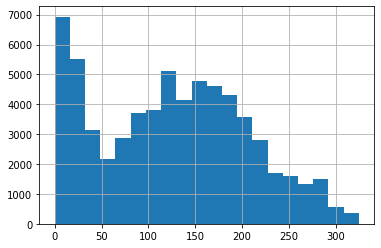

In [65]:
#make collumn for normalized recruiting rankings
plot = recruiting_pd.points.hist(bins=20)

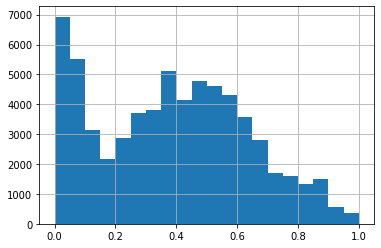

In [64]:
max_recruiting_ranking = recruiting_pd.points.max()
recruiting_pd['points_norm'] = recruiting_pd.points.divide(max_recruiting_ranking)
plot = recruiting_pd.points_norm.hist(bins=20)

In [98]:
#get unique teams
teams = game_df[['home_team','away_team']].values.ravel()
teams_games = pd.unique(teams)
teams_recruiting = pd.unique(recruiting_pd.team.values)

In [185]:
teams_games.size

1342

In [99]:
teams_recruiting.size

253

In [400]:
team_index_dict = {team:index+1 for index, team in enumerate(teams_games)}
index_team_dict = {index+1:team for index, team in enumerate(teams_games)}

In [182]:
from IPython import display
import torch.nn as nn
import torch
#prepare torch
dtype = torch.float
device = torch.device("cpu")
#device = torch.device("cuda:0")

In [516]:
def build_game_lists(df,teams_year,len_padding,team_index_year_dict):    
    oppList = []
    uncList = []
    scoreList = []
    #oppList.append(torch.zeros(1,len_padding,dtype=torch.long)[0])
    #uncList.append(torch.zeros(1,len_padding,dtype=torch.float).fill_(99999999)[0])
    #scoreList.append(torch.zeros(1,len_padding,dtype=torch.float)[0])
    for index, team in enumerate(teams_year):
        home_games = df[(df.home_team==team)]
        away_games = df[(df.away_team==team)]
        #if home_games.shape[0]+away_games.shape[0] < 6: continue
        home_opp = [team_index_year_dict[team_opp] for team_opp in home_games.away_team.values]
        away_opp = [team_index_year_dict[team_opp] for team_opp in away_games.home_team.values]
        home_mov = (home_games.home_points-home_games.away_points).values
        away_mov = (away_games.away_points-away_games.home_points).values
        append_opp = np.append(home_opp, away_opp)
        n_games = len(append_opp)
        pad_len = len_padding-n_games
        append_opp = np.pad(append_opp,  pad_width=(0,pad_len))
        uncertainty_list = np.append(np.full((n_games),13),np.full((pad_len),9999999))
        append_score = np.append(home_mov, away_mov)
        append_score = np.pad(append_score,  pad_width=(0,len_padding-len(append_score)))
        opp = torch.LongTensor(append_opp)
        scores = torch.FloatTensor(append_score)
        uncerts = torch.FloatTensor(uncertainty_list)
        uncList.append(uncerts)
        oppList.append(opp)
        scoreList.append(scores)
        #if index > 10: break
    opp_stack = torch.stack(oppList)
    uncert_stack = torch.stack(uncList)
    score_stack = torch.stack(scoreList)
    return opp_stack, uncert_stack, score_stack

In [581]:
def minimize(opp_stack, uncert_stack, score_stack,prior_power,prior_unc,padd_to,iters):
    n_teams_p_1 = opp_stack.shape[0]       
    team_power = torch.zeros(n_teams_p_1,1,dtype=dtype)
    team_unc = torch.zeros(n_teams_p_1,1,dtype=dtype).fill_(99999999)
    team_prior_power = torch.FloatTensor(prior_power).view(-1,1)
    team_prior_unc = torch.FloatTensor(prior_unc).view(-1,1)

    #create embeddings
    team_power_emb = nn.Embedding.from_pretrained(team_power)
    team_unc_emb = nn.Embedding.from_pretrained(team_unc)
    team_prior_power_emb = nn.Embedding.from_pretrained(team_prior_power)
    team_prior_unc_emb = nn.Embedding.from_pretrained(team_prior_unc)
    for i in range(iters):
        game_scores = team_power_emb(opp_stack).view(-1,padd_to)+score_stack
        opp_unc = team_unc_emb(opp_stack).view(-1,padd_to)
        total_uncert = (opp_unc.pow(2)+uncert_stack.pow(2)).pow(.5)
        #add in prior
        game_scores = torch.cat([game_scores,team_prior_power], dim=1)
        total_uncert = torch.cat([total_uncert,team_prior_unc], dim=1)
        
        weights = 1/total_uncert.pow(2)
        team_power = ((game_scores*weights)/weights.sum(dim=1).view(-1,1)).sum(dim=1).view(-1,1)

        team_unc = (1/weights.sum(dim=1).view(-1,1)).pow(.5)
        team_unc_emb = nn.Embedding.from_pretrained(team_unc)
    return team_power.numpy(), team_unc.numpy()
    #team_power_emb = nn.Embedding.from_pretrained(team_power)  
    

In [589]:
year_list = np.linspace(min_year, 2019, max_year-min_year+1,dtype=int)
year_dict = {}
debug =  False
for year in year_list:
    year_dict[year] = {}
    # process data for minimization
    padd_to = 20
    year_df = game_df[game_df.season==year]
    teams_non_unique_year = year_df[['home_team','away_team']].values.ravel()
    teams_year = ["na"]
    teams_year.extend(pd.unique(teams_non_unique_year))
    print(year, len(teams_year))
    team_index_year_dict = {team:index for index, team in enumerate(teams_year)}
    index_team_year_dict = {index:team for index, team in enumerate(teams_year)}
    opp_stack, uncert_stack, score_stack = build_game_lists(year_df,teams_year,padd_to,team_index_year_dict)
   
    #get preseason vals:
    prior_power = [0 for _ in teams_year]
    prior_unc = [99999 for _ in teams_year]
    if year-1 in year_dict:
        for t,p,u in year_dict[year-1]:
            if t in team_index_year_dict: 
                index = team_index_year_dict[t]
                prior_power[index] = p
                prior_unc[index] = 10

    if debug: #prints out opponents and scores
        for i,(team,s,o) in enumerate(zip(teams_year,score_stack.numpy(),opp_stack.numpy())):
            teams = list(map(lambda x: index_team_year_dict[x],o))
            prior_val = prior_power[i]
            prior_unc_val = prior_unc[i]
            print(team, prior_val, prior_unc_val)
            print(s)
            print(teams)
    # minimize
    team_power, team_unc = minimize(opp_stack, uncert_stack, score_stack,prior_power,prior_unc,padd_to,1000)
    
    results = [[t,p[0],u[0]] for t,p,u in zip(teams_year,team_power,team_unc)]
    year_dict[year] = sorted(results, key=lambda x : -x[1])  
print(year)
for i,(t,p,u) in enumerate(year_dict[year]):
    print(i, t, p, u)

2003 176
2004 172
2005 167
2006 180
2007 187
2008 190
2009 196
2010 196
2011 198
2012 206
2013 211
2014 210
2015 209
2016 217
2017 213
2018 220
2019 218
2019
0 Ohio State 31.312517 3.385135
1 Clemson 30.08943 3.3068771
2 Alabama 28.013191 3.5207582
3 LSU 24.402618 3.3064342
4 UCF 19.712399 3.5287347
5 Appalachian State 18.739367 3.4063268
6 Penn State 18.496078 3.5194085
7 Notre Dame 18.08013 3.5006988
8 Georgia 17.874083 3.4053786
9 Oregon 17.200785 3.4408581
10 Florida 16.35009 3.5456154
11 Wisconsin 16.123665 3.3866878
12 Utah 16.026539 3.406701
13 Louisiana 14.862735 3.4125357
14 Oklahoma 14.270462 3.4126105
15 Memphis 13.342738 3.4132154
16 Auburn 12.831916 3.5256472
17 Boise State 12.6255865 3.4051204
18 Air Force 12.441172 3.5278368
19 Washington 12.069453 3.5259356
20 Florida Atlantic 12.016198 3.4055336
21 Iowa 11.847698 3.5006728
22 Navy 11.695594 3.5211737
23 Baylor 11.443587 3.4129853
24 Michigan 11.4280615 3.4995384
25 Minnesota 10.464073 3.5602264
26 Cincinnati 9.557266 3

In [488]:
year_list = [2018,2019]
team_power = torch.zeros(teams_games.size+1,1,dtype=dtype)
team_unc = torch.zeros(teams_games.size+1,1,dtype=dtype).fill_(99999999)
team_prior_power = torch.zeros(teams_games.size+1,1,dtype=dtype)
team_prior_unc = torch.zeros(teams_games.size+1,1,dtype=dtype).fill_(99999999)

#create embeddings
team_power_emb = nn.Embedding.from_pretrained(team_power)
team_unc_emb = nn.Embedding.from_pretrained(team_unc)
team_prior_power_emb = nn.Embedding.from_pretrained(team_prior_power)
team_prior_unc_emb = nn.Embedding.from_pretrained(team_prior_unc)

In [329]:
team_game_dict = {}
len_padding = 22
processed_games = {}
import pprint
for year in year_list:
    processed_games[year] = {}
    oppList = []
    scoreList = []
    teamList = []
    oppList.append(torch.zeros(1,len_padding,dtype=torch.long)[0])
    scoreList.append(torch.zeros(1,len_padding,dtype=torch.float)[0])
    for index, team in enumerate(team_index_dict):
        home_games = game_df[(game_df.home_team==team) & (game_df.season==year)]
        away_games = game_df[(game_df.away_team==team) & (game_df.season==year)]
        #if home_games.shape[0]+away_games.shape[0] < 6: continue
        home_opp = [team_index_dict[team_opp] for team_opp in home_games.away_team.values]
        away_opp = [team_index_dict[team_opp] for team_opp in away_games.away_team.values]
        home_mov = (home_games.home_points-home_games.away_points).values
        away_mov = (away_games.away_points-away_games.home_points).values
        #home_scores = [for team_opp in home_games.away_team.values]
        append_opp = np.append(home_opp, away_opp)
        append_opp = np.pad(append_opp,  pad_width=(0,len_padding-len(append_opp)))
        append_score = np.append(home_mov, away_mov)
        append_score = np.pad(append_score,  pad_width=(0,len_padding-len(append_score)))
        opp = torch.LongTensor(append_opp)
        scores = torch.FloatTensor(append_score)
        #processed_games[year][team] = {}
        #processed_games[year][team]["opp"] = opp
        #processed_games[year][team]["scores"] = scores
        #processed_games[year][team]["index"] = torch.LongTensor([team_index_dict[team]])
        oppList.append(opp)
        scoreList.append(scores)
        #if index > 10: break
    processed_games[year]["opps"] = torch.stack(oppList)
    processed_games[year]["scores"] = torch.stack(scoreList)
    

In [266]:
processed_games

{2018: {'opps': tensor([[  0,   0,   0,  ...,   0,   0,   0],
          [620, 261, 134,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          ...,
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0]]),
  'scores': tensor([[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [ 28., -29.,  -7.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          ...,
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  0.,   0.,   0.,  ...,   0.,   0.,   0.]])},
 2019: {'opps': tensor([[  0,   0,   0,  ...,   0,   0,   0],
          [ 30, 140, 354,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          ...,
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0]]),
  'scores'

In [430]:
for year in processed_games:
    print (year)
    for team in  processed_games[year]:
        for i in range(1000):
            opp_power = team_power_emb(processed_games[year]['opps']).view(-1,22)
            opp_unc = team_unc_emb(processed_games[year]['opps']).view(-1,22)
            opp_unc = 1/opp_unc.pow(2)
            scores = processed_games[year]['scores']
            team_power = (((opp_power+scores)*opp_unc)/opp_unc.sum(dim=1).view(-1,1)).sum(dim=1).view(-1,1)
            team_power_emb = nn.Embedding.from_pretrained(team_power)
            #team_unc = (1/opp_unc.sum(dim=1).view(-1,1)).pow(.5)
            #team_unc_emb = nn.Embedding.from_pretrained(team_unc)
print("ok")

2018
2019
ok


In [425]:
powers = []
for index, power in enumerate(team_power):
    if index> 0 and power[0].numpy()!=0: powers.append((index_team_dict[index],power[0].numpy()))

In [431]:

powers = sorted(powers, key=lambda x: x[1])
pprint.pprint(powers)

[('UMass', array(-26.31077, dtype=float32)),
 ('Akron', array(-18.567667, dtype=float32)),
 ('Bowling Green', array(-17.817635, dtype=float32)),
 ('Connecticut', array(-15.953674, dtype=float32)),
 ('New Mexico State', array(-15.899261, dtype=float32)),
 ('Rutgers', array(-15.644617, dtype=float32)),
 ('UTEP', array(-13.464966, dtype=float32)),
 ('Texas State', array(-11.383506, dtype=float32)),
 ('New Mexico', array(-11.326677, dtype=float32)),
 ('Old Dominion', array(-10.298685, dtype=float32)),
 ('UT San Antonio', array(-9.58112, dtype=float32)),
 ('Georgia Tech', array(-9.32504, dtype=float32)),
 ('Nevada', array(-9.298865, dtype=float32)),
 ('Arkansas', array(-8.656139, dtype=float32)),
 ('Vanderbilt', array(-8.1206, dtype=float32)),
 ('Kansas', array(-6.9479256, dtype=float32)),
 ('South Alabama', array(-6.1437874, dtype=float32)),
 ('UNLV', array(-5.362569, dtype=float32)),
 ('Miami (OH)', array(-5.2857585, dtype=float32)),
 ('Western Carolina', array(-5.2, dtype=float32)),
 ('E

In [368]:
for year in processed_games:
    for team in  processed_games[year]:
        opp_power = team_power(processed_games[year][team]['opp'])
        scores = processed_games[year][team]['scores'].view(-1,1)
        sigma = team_unc(processed_games[year][team]['opp'])
        tp_power = team_prior_power(processed_games[year][team]["index"])
        tp_unc = team_prior_unc(processed_games[year][team]["index"])
        means = opp_power+scores
        means = torch.cat((means,tp_power))
        sigma = torch.cat((sigma,tp_unc))
        weight = 1/sigma.pow(2)
        break
    break

IndexError: too many indices for tensor of dimension 2